# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [65]:
!pip install CatBoost

In [66]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder

from pandas.core.common import SettingWithCopyWarning
import warnings

from catboost import CatBoostRegressor
from catboost import cv
from catboost import Pool
import catboost as cat

from lightgbm import LGBMRegressor
import lightgbm as lgb

Загрузим данные и выведем таблицу на экран, проверим на наличие пропусков, количество столбцов и строк

In [67]:
car_frame = pd.read_csv('/content/autos.csv')

In [68]:
car_frame.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [69]:
car_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [70]:
report = car_frame.isna().sum().to_frame()
report = report.rename(columns={0: 'missing_values'})
report['% of total'] = (report['missing_values'] /car_frame.shape[0]).round(2)
print (report.sort_values(by='missing_values', ascending=False))

                   missing_values  % of total
NotRepaired                 71154        0.20
VehicleType                 37490        0.11
FuelType                    32895        0.09
Gearbox                     19833        0.06
Model                       19705        0.06
DateCrawled                     0        0.00
Price                           0        0.00
RegistrationYear                0        0.00
Power                           0        0.00
Kilometer                       0        0.00
RegistrationMonth               0        0.00
Brand                           0        0.00
DateCreated                     0        0.00
NumberOfPictures                0        0.00
PostalCode                      0        0.00
LastSeen                        0        0.00


Исходя из вышеперечисленных данных мы видим: приизнаки NotRepaired, VehicleType, FuelType, Gearbox, Model (обозначим их как "Категор/столбцы") имееют достаточное количество пропусков, в первом столбце размер пропусков достигает почти 1/5 от всего датафрейма. Кроме того эти значения в этих столбцах являются категориальными. Эти параметры будут необходимы нам для построения моделей. Catboost сможет их обработать, однако перед построением моделей необходимо избавиться от пропусков, посмотреть аномалии, а также мы используем два метода: 1) закодируем все "Категор/столбцы" 2) оставим все как есть. Начнем избавляться от пропусков. 

### Проверка на пропуски

В первую очередь, мы видим, что у нас есть строки, где как минимум по 3 пропуска в наших категориальных столбцах. Изучив документацию, я понял что, прежде чем точечно заполнять данные по каждому столбцу, необходимо в общем посмотреть, где пропущено максимальное количесвто значений. Указав параметр "thresh", который будет искать в нашем случае 3 пропуска и более в Категор/столбцах, "dropna" удалит такие строки. После этого посмотрим количество строк, которые были удалены.

In [71]:
car_frame.dropna(subset=['NotRepaired','Gearbox','FuelType', 'VehicleType','Model'], thresh=3, inplace=True)

In [72]:
car_frame

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354363,2016-03-27 20:36:20,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no,2016-03-27 00:00:00,0,26624,2016-03-29 10:17:23
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


In [73]:
report = car_frame.isna().sum().to_frame()
report = report.rename(columns={0: 'missing_values'})
report['% of total'] = (report['missing_values'] /car_frame.shape[0]).round(2)
print (report.sort_values(by='missing_values', ascending=False))

                   missing_values  % of total
NotRepaired                 55104        0.16
VehicleType                 22122        0.07
FuelType                    18540        0.06
Model                       12016        0.04
Gearbox                      8954        0.03
DateCrawled                     0        0.00
Price                           0        0.00
RegistrationYear                0        0.00
Power                           0        0.00
Kilometer                       0        0.00
RegistrationMonth               0        0.00
Brand                           0        0.00
DateCreated                     0        0.00
NumberOfPictures                0        0.00
PostalCode                      0        0.00
LastSeen                        0        0.00


In [74]:
car_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336341 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        336341 non-null  object
 1   Price              336341 non-null  int64 
 2   VehicleType        314219 non-null  object
 3   RegistrationYear   336341 non-null  int64 
 4   Gearbox            327387 non-null  object
 5   Power              336341 non-null  int64 
 6   Model              324325 non-null  object
 7   Kilometer          336341 non-null  int64 
 8   RegistrationMonth  336341 non-null  int64 
 9   FuelType           317801 non-null  object
 10  Brand              336341 non-null  object
 11  NotRepaired        281237 non-null  object
 12  DateCreated        336341 non-null  object
 13  NumberOfPictures   336341 non-null  int64 
 14  PostalCode         336341 non-null  int64 
 15  LastSeen           336341 non-null  object
dtypes: int64(7), object(

In [75]:
drop_frame = 354369 - 336341
print("Была удалена следующая часть датафрейма:",drop_frame / car_frame.shape[0])

Была удалена следующая часть датафрейма: 0.05360036391638248


Избавимся от столбцов "NumberOfPictures","PostalCode", "LastSeen", они в нашем исследовании не понадобятся

In [76]:
car_frame = car_frame.drop(["NumberOfPictures","PostalCode", "LastSeen"],axis=1)

### NotRepaired

In [77]:
car_frame['NotRepaired'].value_counts()

no     245746
yes     35491
Name: NotRepaired, dtype: int64

Начнем с главного столбца с пропусками, где надо указать, чинилась машина или нет. 

  К сожалению мы не сможем сказать чинилась машина или нет на основании данных признаков. Можно было сделать вывод из пройденных километров, однако нам не даны четкие параметры, что чинилось: это может быть и замена бокового стекла или полностью ходовой части, а может быть машина просто красилась. Поэтому здесь мы будем предпологать, что там где у нас есть пропуски означает, что машина не чинилась. Заполним их значением yes. 

In [78]:
car_frame.fillna({'NotRepaired':'yes'},inplace=True)

### Gearbox

In [79]:
car_frame['Gearbox'].value_counts()

manual    262289
auto       65098
Name: Gearbox, dtype: int64

Пропуски в столбце Gearbox составляют всего 3 процента от всего датафрейма, попробуем найти зависимость между коробкой передач и датой регистрации машины. Проведем небольшое исследование: установим за точку отсчета 2000 г. и посмотрим, какое соотношение было между количеством ручной и автоматической коробок передач

In [80]:
car_gearbox = car_frame.query('2000 > RegistrationYear')

In [81]:
car_gearbox['Gearbox'].value_counts()

manual    80386
auto      14712
Name: Gearbox, dtype: int64

In [82]:
car_gearbox['Gearbox'].isna().sum()

2804

In [83]:
car_gearbox2 = car_frame.query('2000 < RegistrationYear')

In [84]:
car_gearbox2['Gearbox'].isna().sum()

5584

Количество машин с ручной коробкой передач превышает количество с автоматической в несколько раз. После 2000 г. соотношение увеличивается в пользу АКПП, однако разрыв все равно большой. Принимая во внимание, что дальше мы будем искать аномальные значения по годам и удалять выбивающие значения, наш период изучения будет примерно 1960 - 2018 г., в это время уже начали внедрять АКПП, а значит мы можем заменить все пропущенные значения на АКПП

Для того,чтобы проверить как менялись тренды с коробкой передач мы построим график, на котором будет показано количество машин с акпп и мкпп. Только сейчас понял, что необходимо было сначала исследовать год регистрации, а потом уже переходить к категориальным признакам, иначе выбросы по годам не дадут нам оптимальной картины. График будет построен чуть ниже, после удаления аномалий из времени регистрации.

In [85]:
car_frame['Gearbox'].value_counts()

manual    262289
auto       65098
Name: Gearbox, dtype: int64

### RegistrationYear, Price, Power	

Перед тем, как продолжить изучать Категор/столбцах, обратим внимание на наши количественные признаки, есть ли какие либо выбивающиеся значения

In [86]:
car_frame['RegistrationYear'].value_counts()

1999    22446
2000    21174
2005    20597
2001    19941
2006    19641
        ...  
2900        1
6500        1
1400        1
4000        1
1600        1
Name: RegistrationYear, Length: 108, dtype: int64

Мы видим, что есть значения в далеком прошлом и в чрезмерно далеком будущем. Чтобы понять, до какой даты мы можем считать значения как правильные, посмотрим на максимальное значение "DateCrawled" (дата скачивания анкеты из базы)

In [87]:
date = pd.to_datetime(car_frame['DateCrawled'])
date.max()

Timestamp('2016-04-07 14:36:58')

Все, что позднее 2016 года, мы можем считать неправильными значениями. За нижнюю планку изначально возьмем 1919 г., начало эры винтажных автомобилей и посмотрим на распределения по годам

count    325870.000000
mean       2002.540651
std           6.673017
min        1923.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: RegistrationYear, dtype: float64

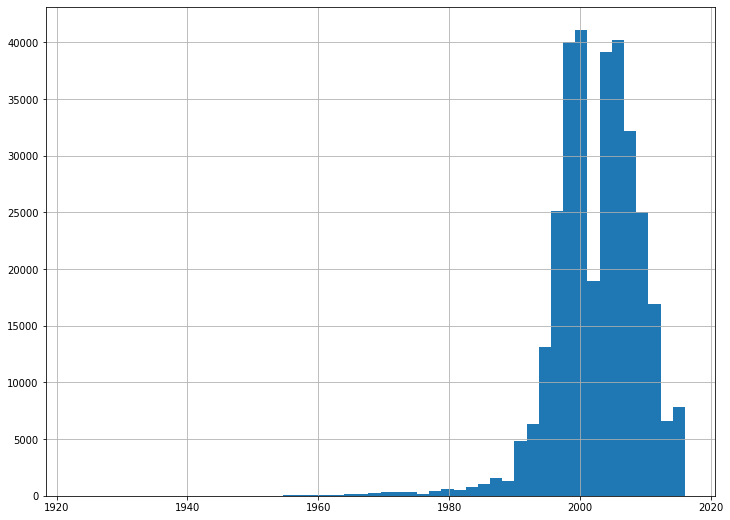

In [88]:
car_frame = car_frame.query('1919 < RegistrationYear < 2017')
car_frame['RegistrationYear'].hist(bins=50, figsize=(12,9))
car_frame['RegistrationYear'].describe()

Среднее и медианна примерно одинаковы, мы видим, что до 1980 г. количество маши было минимальным, в то время как в 1990 г. присходит резкий скачок. Наш 25% находится на отметке 1999 г., однако указав его мы потеряем некоторое количество раритетных машин, которые тоже могут находится в рабочем состоянии. 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


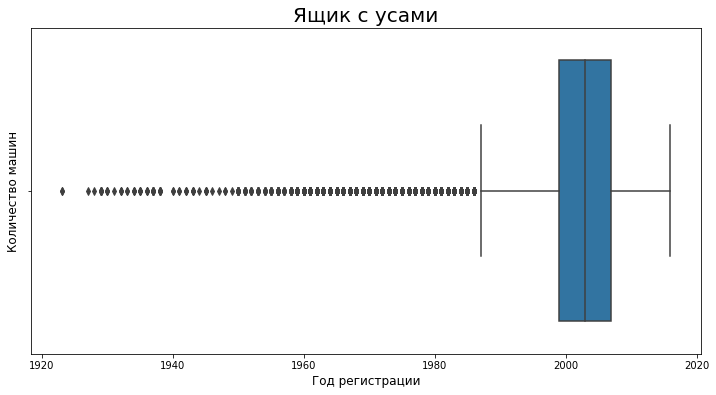

In [89]:
plt.figure(figsize=(12,6))
sns.boxplot(car_frame['RegistrationYear'])
plt.title('Ящик с усами', fontsize=20)
plt.xlabel('Год регистрации', fontsize=12)
plt.ylabel('Количество машин',fontsize=12)
plt.show()

В итоге, я решил отталкиваться от следующего: согласно официальным данным, статус раритеного автомобиля можно получить, если машина эксплуатировалась более 50 лет. Все машины, старее этой даты, должны уже стоять в музее, либо использоваться на выставках, для езды они могут уже быть не предназначены.

In [90]:
car_frame = car_frame.query('1967 < RegistrationYear < 2017')

In [91]:
car_frame.shape[0]

325112

### Gearbox.2.0

Ниже построим график по годам для исследования пропусков в 'Gearbox', первоначально разделим выборки на АКПП и МКПП

In [92]:
car_frame['Gearbox'].isna().sum()

8507

In [93]:
a = car_frame.query('1999 < RegistrationYear < 2010')
a['Gearbox'].isna().sum()

5048

In [94]:
car_manual = car_frame.query('Gearbox == "manual"')
car_auto = car_frame.query('Gearbox == "auto"')

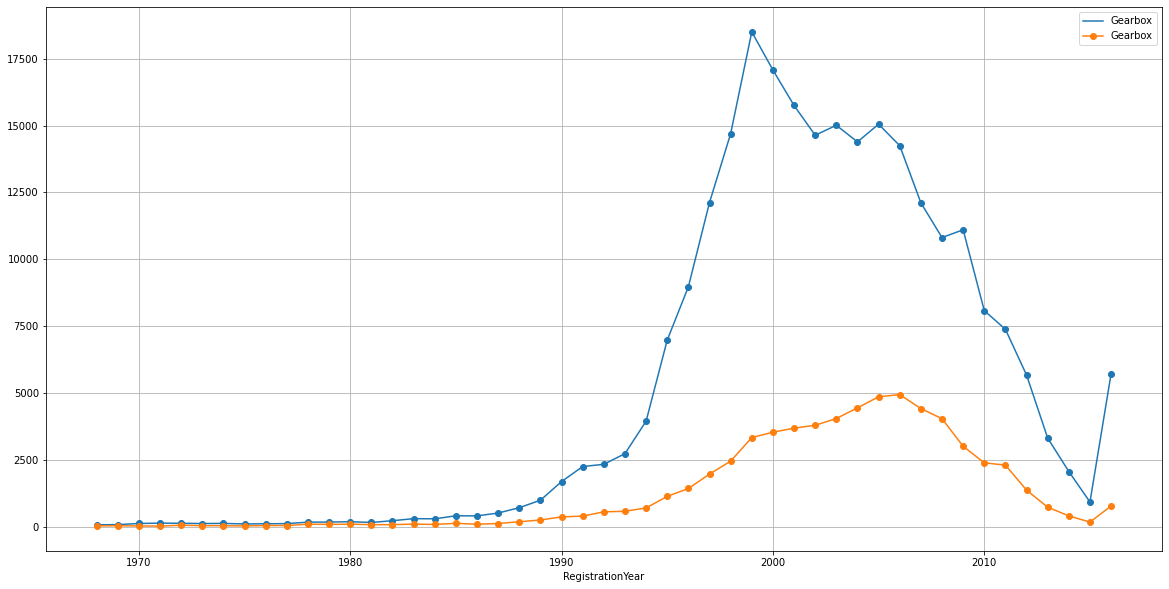

In [95]:
car_manual.groupby('RegistrationYear')['Gearbox'].count().plot(
    style='o-', grid=True, figsize=(20,10), legend=True
    )

car_auto.groupby('RegistrationYear')['Gearbox'].count().plot(
    style='o-', grid=True, figsize=(20,10), legend=True
    )

plt.show()

In [96]:
car_frame.fillna({'Gearbox':'auto'}, inplace=True)

In [97]:
car_manual = car_frame.query('Gearbox == "manual"')
car_auto = car_frame.query('Gearbox == "auto"')

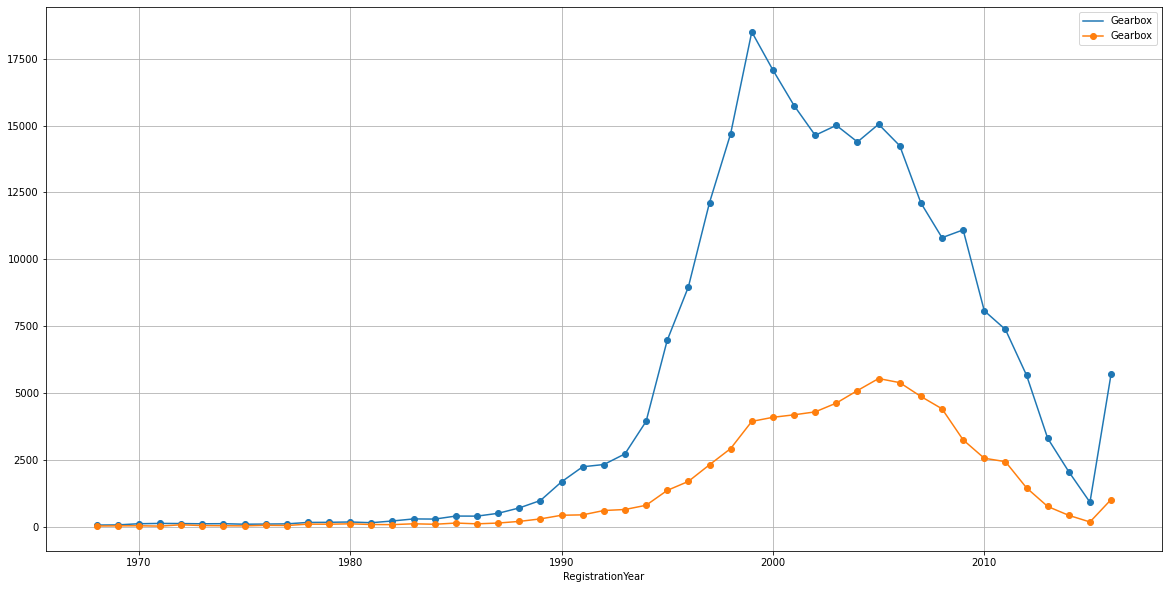

In [98]:
car_manual.groupby('RegistrationYear')['Gearbox'].count().plot(
    style='o-', grid=True, figsize=(20,10), legend=True
    )

car_auto.groupby('RegistrationYear')['Gearbox'].count().plot(
    style='o-', grid=True, figsize=(20,10), legend=True
    )

plt.show()

Долго думал над этим вопросом, к однозначому мнению, к сожалению, не пришел. Просто заменять на Unknown не хотелось бы. Согласно данным большинство пропусков находится в период с 1999 по 2010 гг., и на первом графике мы видим, что как раз в это время количество машин с МКПП начинает сокращаться, в то время как доля машин с АКПП растет(однако не такими быстрыми темпами). Пиком для АКПП стал 2005 - 2006 г., потом доля тоже стала уменьшатся. Я все же решил оставить заполнение пропусков АКПП, исходя из того, что на данный момент машины с АКПП  выпускаются чаще. Так же в конце проекта исследовали важность параметров, параметр "Gearbox" находится в конце списка и имеет небольшое влияние на результат.

Теперь проверим "Power" (мощность в л.с.)

In [99]:
car_frame['Power'].value_counts()

0       27489
75      22211
60      14715
150     13910
101     12493
        ...  
1999        1
584         1
1054        1
851         1
1241        1
Name: Power, Length: 687, dtype: int64

В первую очередь, мы видим, что есть много автомобилей со значением 0 в л.с. Попробуем посмотреть, сколько из них имеют 0 цену, если найде такие - то примем решение избавиться, т.к. машины, которые не на ходу и которые не стоит ничего нас не интересуют.

In [100]:
car_frame.query('Power == 0 & Price == 0')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated
590,2016-03-20 02:36:22,0,sedan,1997,manual,0,3er,150000,0,petrol,bmw,yes,2016-03-20 00:00:00
950,2016-03-26 19:47:19,0,small,2000,manual,0,corsa,150000,5,petrol,opel,no,2016-03-26 00:00:00
1034,2016-04-04 00:58:53,0,sedan,1999,manual,0,espace,150000,3,petrol,renault,no,2016-04-04 00:00:00
1114,2016-03-27 17:56:57,0,suv,2008,auto,0,other,30000,12,petrol,toyota,yes,2016-03-27 00:00:00
1419,2016-03-05 20:48:33,0,wagon,2000,manual,0,NaN,150000,11,gasoline,mazda,yes,2016-03-05 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
353387,2016-03-06 00:57:04,0,NaN,2007,manual,0,NaN,50000,2,petrol,bmw,no,2016-03-05 00:00:00
353411,2016-03-16 14:38:38,0,small,1989,manual,0,other,125000,3,NaN,fiat,yes,2016-03-16 00:00:00
353480,2016-03-16 01:00:05,0,NaN,2016,auto,0,megane,20000,0,gasoline,renault,yes,2016-03-15 00:00:00
353511,2016-03-17 14:48:07,0,small,1996,manual,0,fiesta,100000,11,petrol,ford,yes,2016-03-17 00:00:00


In [101]:
car_frame = car_frame.query('Power != 0 | Price != 0')

In [102]:
car_frame.shape[0]

323437

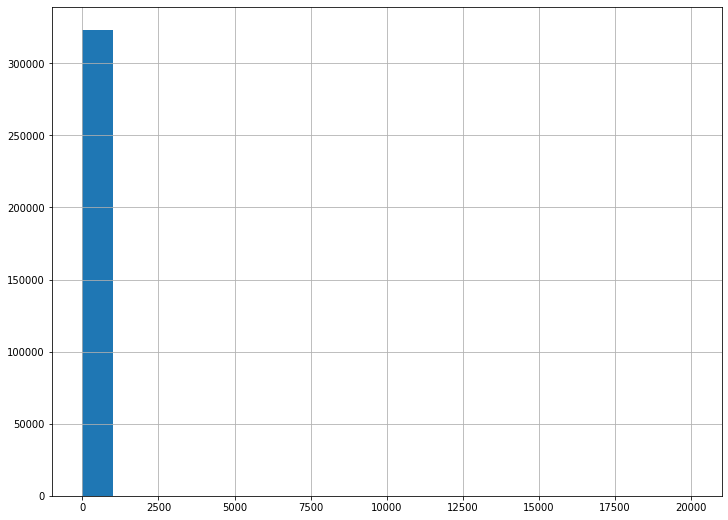

In [103]:
car_frame['Power'].hist(bins=20, figsize=(12,9))

Проверим теперь по максимальным параметрам Power. Самая мощная машина (данные из Интернета) Devel Sixteen  = 5000 л. с. Возьмем это как максимальную точку

In [104]:
car_frame.query('Power > 5000') 

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated
7661,2016-04-02 19:25:25,1499,small,1999,manual,7515,lupo,150000,4,petrol,volkswagen,yes,2016-04-02 00:00:00
11039,2016-03-25 19:55:32,0,sedan,1998,manual,10317,other,150000,8,petrol,fiat,no,2016-03-25 00:00:00
25232,2016-03-28 19:57:39,10900,bus,2009,manual,10520,caddy,150000,6,gasoline,volkswagen,no,2016-03-28 00:00:00
33952,2016-03-09 11:37:03,3740,small,2006,manual,6920,aygo,90000,10,NaN,toyota,no,2016-03-09 00:00:00
44520,2016-03-10 22:37:21,2500,convertible,1998,manual,7512,golf,150000,6,NaN,volkswagen,yes,2016-03-10 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
328862,2016-03-20 09:57:28,850,small,2000,manual,8500,corsa,150000,3,petrol,opel,no,2016-03-20 00:00:00
339642,2016-03-07 16:58:44,600,sedan,2000,manual,10110,focus,125000,12,petrol,ford,yes,2016-03-07 00:00:00
341320,2016-03-29 21:40:33,1899,other,2006,manual,7518,berlingo,125000,11,petrol,citroen,yes,2016-03-29 00:00:00
346639,2016-03-25 12:55:36,1300,sedan,2000,manual,12512,carisma,150000,9,petrol,mitsubishi,yes,2016-03-25 00:00:00


In [105]:
car_frame = car_frame.query('Power < 5000')

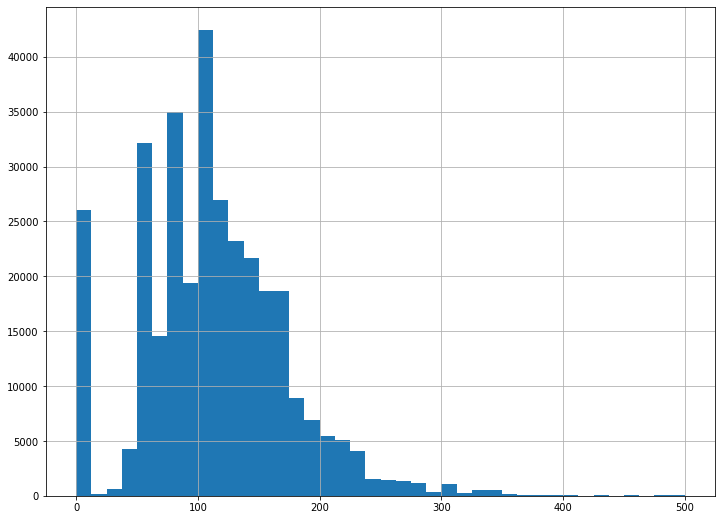

In [106]:
car_frame['Power'].hist(bins=40, range=(0,500), figsize=(12,9))

Построил еще раз гистограмму мощности, немного сократим размер разброса. Большинство значений лежит в пределах 300 л.с.

In [107]:
car_frame.shape[0]

323364

Также обратим внимание, что в данных в столбце "RegistrationMonth" есть значение 0. Хоть данный столбец и не обязателен для модели, избавимся от 0 и заполним его любым значением, выберем июнь

In [108]:
car_frame.loc[car_frame['RegistrationMonth'] == 0, 'RegistrationMonth'] = 6

In [109]:
report = car_frame.isna().sum().to_frame()
report = report.rename(columns={0: 'missing_values'})
report['% of total'] = (report['missing_values'] /car_frame.shape[0]).round(2)
print (report.sort_values(by='missing_values', ascending=False))

                   missing_values  % of total
FuelType                    15639        0.05
VehicleType                 11319        0.04
Model                       11149        0.03
DateCrawled                     0        0.00
Price                           0        0.00
RegistrationYear                0        0.00
Gearbox                         0        0.00
Power                           0        0.00
Kilometer                       0        0.00
RegistrationMonth               0        0.00
Brand                           0        0.00
NotRepaired                     0        0.00
DateCreated                     0        0.00


### VehicleType, FuelType, Model

Рассмотрим столбец "VehicleType" (тип автомобильного кузова)

In [110]:
car_frame['VehicleType'].value_counts()

sedan          90231
small          78523
wagon          64379
bus            28427
convertible    19863
coupe          15805
suv            11781
other           3036
Name: VehicleType, dtype: int64

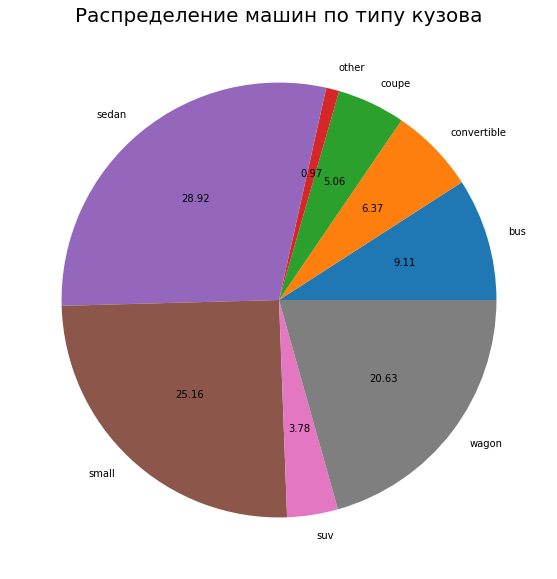

In [111]:
count_vehicle = car_frame.groupby('VehicleType')['VehicleType'].count()
vehicle_name = count_vehicle.index
plt.figure(figsize=(10,10))
plt.pie(x = count_vehicle, labels=vehicle_name, autopct="%.2f")
plt.title('Распределение машин по типу кузова', fontsize=20)
plt.show()

In [112]:
car_frame.fillna({'VehicleType':'other'}, inplace=True)

Мы видим, что у нас есть машины с типом кузова "other". Присвоим всем Nan данный тип кузова. Таким же образом поступим с Типом двигателя и моделью

In [113]:
car_frame['FuelType'].value_counts()

petrol      206347
gasoline     95305
lpg           5096
cng            535
hybrid         220
other          137
electric        85
Name: FuelType, dtype: int64

In [114]:
car_frame.fillna({'FuelType':'other'}, inplace=True)

In [115]:
car_frame['FuelType'].value_counts()

petrol      206347
gasoline     95305
other        15776
lpg           5096
cng            535
hybrid         220
electric        85
Name: FuelType, dtype: int64

In [116]:
car_frame.fillna({'Model':'unknown'}, inplace=True)

В столбце "Model" (модели машин) заменим пропуски на unknown

Удалим столбцы "DateCrawled" , "DateCreated", они больше нам не понадобятся

In [117]:
car_frame = car_frame.drop(["DateCrawled","DateCreated"], axis=1)

Также создадим матрицу корреляций, проверим нет ли прямой зависимости между числовыми данными в столбцах "Price","Power","Kilometer".

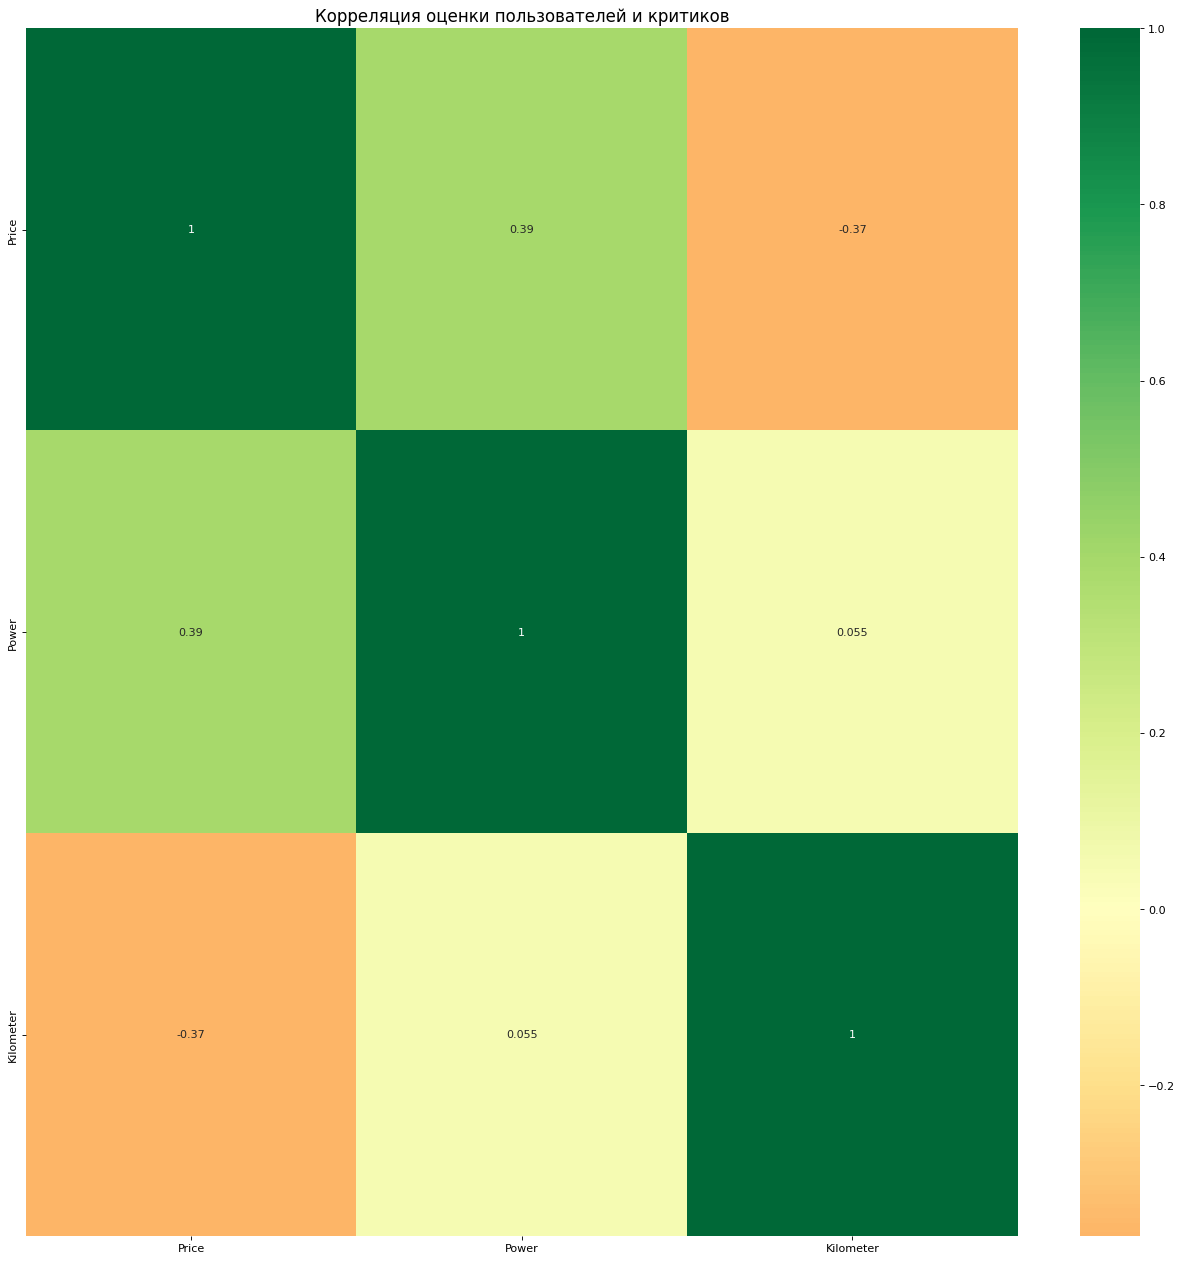

In [118]:
plt.figure(figsize=(20,20), dpi=80)
sns.heatmap(
    car_frame[['Price','Power','Kilometer']].corr(),
    xticklabels = car_frame[['Price','Power','Kilometer']].corr().columns, 
    yticklabels = car_frame[['Price','Power','Kilometer']].corr().columns, 
    cmap='RdYlGn', center = 0, annot=True)

plt.title('Корреляция оценки пользователей и критиков', fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

Сильной корреляции между данными нет

Уменьшим размерность хранения типа для ускорения работы с дата фреймом

In [119]:
car_frame['RegistrationYear'] = pd.to_numeric(car_frame['RegistrationYear'], downcast='integer')
car_frame['Power'] = pd.to_numeric(car_frame['Power'], downcast='integer')
car_frame['Kilometer'] = pd.to_numeric(car_frame['Kilometer'], downcast='integer')
car_frame['Price'] = pd.to_numeric(car_frame['Price'], downcast='integer')
car_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 323364 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              323364 non-null  int16 
 1   VehicleType        323364 non-null  object
 2   RegistrationYear   323364 non-null  int16 
 3   Gearbox            323364 non-null  object
 4   Power              323364 non-null  int16 
 5   Model              323364 non-null  object
 6   Kilometer          323364 non-null  int32 
 7   RegistrationMonth  323364 non-null  int64 
 8   FuelType           323364 non-null  object
 9   Brand              323364 non-null  object
 10  NotRepaired        323364 non-null  object
dtypes: int16(3), int32(1), int64(1), object(6)
memory usage: 22.8+ MB


Один из категориальных столбцов вручную переведем в количественный. Если машина ремонтировалась, то тогда будет указан 0, если не ремонтировалась - то 1

In [120]:
car_frame['NotRepaired'] = pd.Series(np.where(car_frame['NotRepaired'].values == 'yes', 1, 0),car_frame.index)

Выведем окончательную информацию о данных после всех исправлений 

In [121]:
car_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 323364 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              323364 non-null  int16 
 1   VehicleType        323364 non-null  object
 2   RegistrationYear   323364 non-null  int16 
 3   Gearbox            323364 non-null  object
 4   Power              323364 non-null  int16 
 5   Model              323364 non-null  object
 6   Kilometer          323364 non-null  int32 
 7   RegistrationMonth  323364 non-null  int64 
 8   FuelType           323364 non-null  object
 9   Brand              323364 non-null  object
 10  NotRepaired        323364 non-null  int64 
dtypes: int16(3), int32(1), int64(2), object(5)
memory usage: 22.8+ MB


In [122]:
car_frame

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,other,1993,manual,0,golf,150000,6,petrol,volkswagen,1
1,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,1
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,1
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,0
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,0
...,...,...,...,...,...,...,...,...,...,...,...
354362,3200,sedan,2004,manual,225,leon,150000,5,petrol,seat,1
354363,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,0
354366,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,0
354367,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,0


### Вывод по первой главе

В данной главе были проделаны следующие шаги:
 1) данные загружены, проверены столбцы, проверено количество пропусков 
 
 2) мы обратили внимание на каждый столбец, описали по каким параметрам будем заполнять пропущенные данные
 
 3) используя количественные признаки, мы "отсекли" те данные, которые попадали под категорию "выбросы". Под данные категории попали: цена машин и их мощность, значение которых одновременно равно 0, год регистрации машин, который был после даты последнего скачивания анкеты, машины с мощностью, которая больше 5000 л.с. В целом направления для зполнения было выбрано следующим образом: вместо простого удаления данных мы в первую очередь попытались найти те анкеты, данные которых были далеко за "гранью реальности". Очень часто, в анкетах с "неправильными" количественными данными, встречались пропуски в категориальных данных.

 4) проверили на наличие корреальности в количественых данных
 
 5) Уменьшили размерность хранения типа для ускорения работы (до этого проект зависал при обучении моделей)
 
 6) Закодировали столбец 'NotRepaired'


## Обучение моделей

Сделаем копию для нашего дата фрейма: в одной закодируем все категориальные фичи, в другой оставим все как есть. Делаем это для того, чтобы проверить, как будет реагировать Catboost на разную подачу данных. Разобьем обе наших выборки на фичи и таргет(в нашем задании таргетом является цена), после разобьем на тренировочную и тестовую выборки, выведем количество строк в каждой выборке

In [123]:
car_frame_ohe_out = car_frame.copy()
target_out = car_frame_ohe_out['Price']
features_out = car_frame_ohe_out.drop(['Price'], axis=1)

In [124]:
encoder = OrdinalEncoder()
features = car_frame.drop(['Price'],axis=1)
column_encoder = ['VehicleType','FuelType','Gearbox', 'Brand','Model']
features_encoder = features[column_encoder]

Используем OrdinalEncoder() для порядкового кодирования категориальных признаков. Для начала определим столбцы с  категориальными признаками. После создадим датафрейм и преобразуем его значения при помощи OrdinalEncoder().  

In [125]:
features_encoder = pd.DataFrame(
    encoder.fit_transform(features_encoder), columns=features_encoder.columns, 
    index = features_encoder.index
    )

for column in column_encoder:
    features[column] = features_encoder[column]
target = car_frame['Price']


In [126]:
features 

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,3.0,1993,1.0,0,116.0,150000,6,6.0,38.0,1
1,2.0,2011,1.0,190,228.0,125000,5,2.0,1.0,1
2,6.0,2004,0.0,163,117.0,125000,8,2.0,14.0,1
3,5.0,2001,1.0,75,116.0,150000,6,6.0,38.0,0
4,5.0,2008,1.0,69,101.0,90000,7,2.0,31.0,0
...,...,...,...,...,...,...,...,...,...,...
354362,4.0,2004,1.0,225,140.0,150000,5,6.0,30.0,1
354363,0.0,2000,1.0,0,250.0,150000,3,6.0,24.0,0
354366,1.0,2000,0.0,101,106.0,125000,3,6.0,32.0,0
354367,0.0,1996,1.0,102,224.0,150000,3,2.0,38.0,0


In [127]:
train_features, test_features, train_target, test_target = train_test_split(
    features, target, test_size=0.2, random_state=48)

In [128]:
train_features_out, test_features_out, train_target_out, test_target_out = train_test_split(
    features_out, target_out, test_size=0.2, random_state=48
    )

In [129]:
print('Размер тренировочной выборки', train_features.shape[0])
print('Размер тестовой выборки', test_features.shape[0])
print('Размер тренировочной выборки', train_target.shape[0])
print('Размер тестовой выборки', test_target.shape[0])

Размер тренировочной выборки 258691
Размер тестовой выборки 64673
Размер тренировочной выборки 258691
Размер тестовой выборки 64673


### RandomForestRegressor

Первую модель для обучения выберем Лес. Оно не умеет работать с категориальными признаками, поэтому используем ту выборку, где категориальные признаки переведены в численные. Воспользуемся GridSearch для поиска лучших параметров. Скоринг поставим инвертированное значение метрики neg_mean_squared_error, в конце умножим на -1 и найдем корень для получения RMSE

In [130]:
%%time
regr = RandomForestRegressor()
parametrs = { 'n_estimators': range(10, 51, 10),
              'max_depth': range(1,4,2),
              'random_state':[48]}

reg1 = GridSearchCV(regr, parametrs, cv=3, scoring='neg_mean_squared_error')
reg1.fit(train_features, train_target)
reg1pred = reg1.predict(train_features)
fina = (reg1.best_score_* -1) ** 0.5
print(fina)

2892.811397121994
CPU times: user 1min 30s, sys: 477 ms, total: 1min 30s
Wall time: 1min 50s


In [131]:
reg1.best_estimator_

RandomForestRegressor(max_depth=3, n_estimators=50, random_state=48)

In [132]:
%%time
warnings.simplefilter(action='ignore', category=FutureWarning)
reg_final = reg1.best_estimator_
reg_final.fit(train_features, train_target)

CPU times: user 7.29 s, sys: 25.9 ms, total: 7.32 s
Wall time: 7.29 s


In [133]:
%%time
regression_rmse = sqrt(mean_squared_error(test_target, reg_final.predict(test_features)))
print("Значение RMSE для Regression:", regression_rmse)

Значение RMSE для Regression: 2897.3964102622704
CPU times: user 111 ms, sys: 0 ns, total: 111 ms
Wall time: 111 ms


### Catboost

In [134]:
#catboost = CatBoostRegressor(loss_function='RMSE')

In [135]:
#%%time
#parameters_cat = {'depth':[8,10], 'learning_rate':[0.1]}
#catboost_grid = catboost.grid_search(parameters_cat,
            #Pool(train_features_out, train_target_out, cat_features=["VehicleType", "Gearbox",
                                                             #"Model", "FuelType",
                                                             #"Brand", "NotRepaired"]),
            #cv=2,
            #verbose=True,
            #plot=False)

Закомментировал поиск параметров для catboost, он очень долго искал параметры с grid search (около 50 минут), ниже указал, данные, которые он выдал. Лучшая метрика получилась при depth = 10, learning_rate = 0.1.

0:	loss: 1597.4659727	best: 1597.4659727 (0)	total: 8m 35s	remaining: 8m 35s
1:	loss: 1577.2855168	best: 1577.2855168 (1)	total: 20m 57s	remaining: 0us


CPU times: user 49min 28s, sys: 5min 15s, total: 54min 43s
Wall time: 54min 53s

In [136]:
#catboost_grid["params"]

Для catboost используем два набора данных, которые подготовили ранее:
1) "чистые" данные, указав модели в cat_features, какие столбцы являются категориальными и 

2) закодированные категориальные данные. Позднее сравним результат и быстроту обучения. 

Кроме того, для дальнейшего построения графика, где будут обозначено важность того или иного параметра, создадим датафрейм, используя функцию Pool

In [137]:
train_dataset = Pool(train_features_out, train_target_out, cat_features=["VehicleType","Gearbox","Model","FuelType","Brand"])

In [139]:
%%time
final_cat = CatBoostRegressor(depth=10, 
                              learning_rate=0.1,
                              loss_function='RMSE', verbose=200)
final_cat.fit(Pool(train_features_out, train_target_out,
                   cat_features=["VehicleType","Gearbox","Model","FuelType","Brand"]))

0:	learn: 4234.0186160	total: 494ms	remaining: 8m 13s
200:	learn: 1600.3141025	total: 1m 22s	remaining: 5m 28s
400:	learn: 1511.6553734	total: 2m 47s	remaining: 4m 9s
600:	learn: 1448.7283840	total: 4m 12s	remaining: 2m 47s
800:	learn: 1406.2129575	total: 5m 38s	remaining: 1m 24s
999:	learn: 1372.2285179	total: 7m 3s	remaining: 0us
CPU times: user 13min 43s, sys: 4.15 s, total: 13min 48s
Wall time: 7min 6s


In [140]:
%%time
final_cat2 = CatBoostRegressor(depth=10, 
                              learning_rate=0.1,
                              loss_function='RMSE', verbose=200)
final_cat2.fit(Pool(train_features, train_target))

0:	learn: 4245.7691513	total: 124ms	remaining: 2m 3s
200:	learn: 1642.5871648	total: 15.9s	remaining: 1m 3s
400:	learn: 1537.3029944	total: 29.5s	remaining: 44.1s
600:	learn: 1472.0251701	total: 43.1s	remaining: 28.6s
800:	learn: 1423.9120341	total: 1m 4s	remaining: 16s
999:	learn: 1386.1283108	total: 1m 18s	remaining: 0us
CPU times: user 2min 7s, sys: 2.15 s, total: 2min 9s
Wall time: 1min 19s


Посмотрим, что модель покажет на тестовой выборке

In [141]:
%%time
catboost_rmse = sqrt(mean_squared_error(test_target_out, final_cat.predict(test_features_out)))
print("Значение RMSE для CatBoost:", catboost_rmse)

Значение RMSE для CatBoost: 1603.0507835012822
CPU times: user 1.64 s, sys: 3.95 ms, total: 1.65 s
Wall time: 881 ms


In [142]:
%%time
catboost_ohe_rmse = sqrt(mean_squared_error(test_target, final_cat2.predict(test_features)))
print("Значение RMSE для CatBoost:", catboost_ohe_rmse)

Значение RMSE для CatBoost: 1612.8216492591728
CPU times: user 477 ms, sys: 1.98 ms, total: 479 ms
Wall time: 259 ms


### LGBMRegressor

Теперь воспользуемся LGBMRegressor. Основной параметр для обучения является num_leaves, который должен превышать глубину минимум в два раза. Попробуем с помощью Gridsearch найти лучшие параметры

In [143]:
%%time
warnings.simplefilter(action='ignore', category=FutureWarning)
modelLight1 = LGBMRegressor(loss_function='RMSE', n_jobs=-1)
parameters_light = {'depth':[6], 'learning_rate':[0.2], 'num_leaves':[12,18]}

light = GridSearchCV(modelLight1, parameters_light,
            cv=3,
            verbose=True)

light.fit(train_features, train_target)
light.predict(train_features)
light.best_estimator_

Fitting 3 folds for each of 2 candidates, totalling 6 fits
CPU times: user 18.4 s, sys: 125 ms, total: 18.5 s
Wall time: 9.65 s


Создадим модель на основе LGBMRegressor, передадим ей лучшие параметры для обучения

In [144]:
modelLight = LGBMRegressor(depth=6, n_estimators=500, learning_rate=0.2, random_state=42, num_leaves=18)

Для того, чтобы понять правильно ли я использовал формулу для нахождения предсказания, которая включает eval_set и eval_metric, обучим модель, как обычно через fit/predict

In [145]:
%%time
modelLight.fit(train_features, train_target)

CPU times: user 9.2 s, sys: 59.9 ms, total: 9.26 s
Wall time: 4.76 s


LGBMRegressor(depth=6, learning_rate=0.2, n_estimators=500, num_leaves=18,
              random_state=42)

In [146]:
%%time
light_predict = modelLight.predict(test_features)
light_rmse = sqrt((mean_squared_error(test_target, light_predict)))
print("Значение RMSE для LGBMBoost:", light_rmse)

Значение RMSE для LGBMBoost: 1660.716790111193
CPU times: user 1.61 s, sys: 3.99 ms, total: 1.61 s
Wall time: 834 ms


Результаты совпадают

### Вывод по второй главе

Перед обучением моделей мы подготовили наши данные: в первую очередь использовали get_dummies для категориальных признаков, разбили их на тренировочную и тестовую, обозначили features и target. Для поиска лучших параметров для наших иоделей мы использовали Gridsearch. В ходе исследования выяснилось, что поиск моделей для Catboost занимает очень большое количество времени. Использовали для обучения следующие модели: RandomForestRegressor, Catboost, LGBMRegressor

## Анализ моделей

В первую очередь, для оценки моделей проверим какие параметры повлияли на обучение моделей.

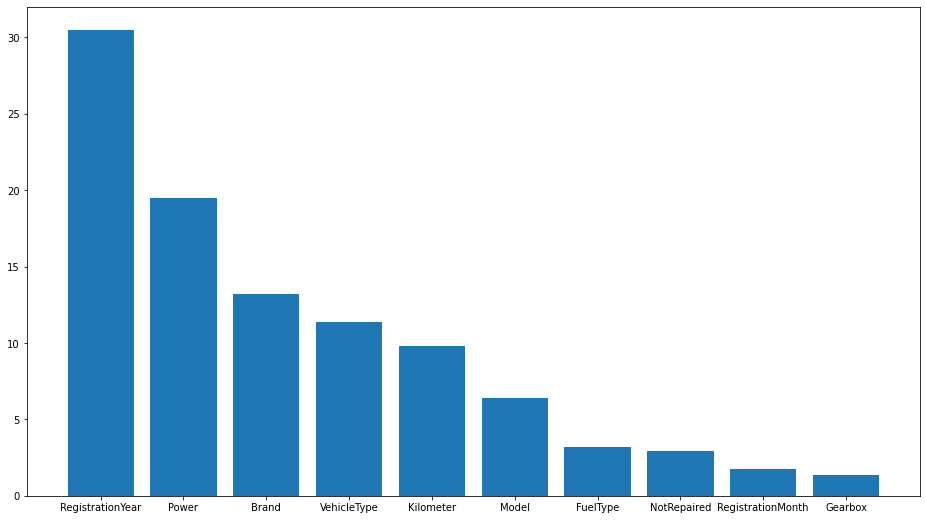

In [147]:
plt.figure(figsize=(16,9))
feature_import = final_cat.get_feature_importance(train_dataset, prettified=True)
plt.bar(feature_import['Feature Id'], feature_import['Importances'])
plt.show()

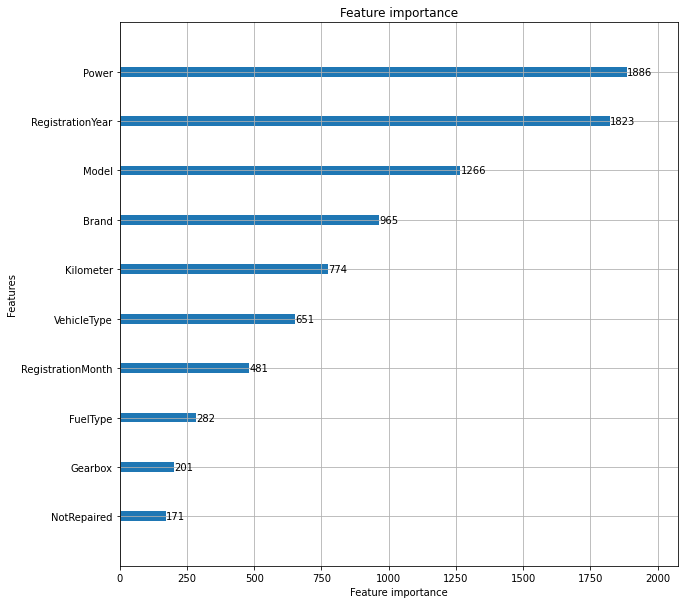

In [148]:
lgb.plot_importance(modelLight, figsize=(10,10))
plt.show()

Исходя из двух графиков, мы видим, что самыми важными параметрами для обеих моделей оказались год регистрации и мощность машины. Большим удивлением для меня оказалось, что месяц регистрации также попал в первую четверку в LGBMBoost

Параметры 'Power' и 'RegistrationYear' поменялись местами в модели LGBMRegressor. Параметр с месяцем регистрации закономерно теперь отошел на задний план. Также исходя из этих графиков мы видим, что наличие автоматической или механической коробки передач не особо влияет на предсказания модели. 

In [149]:
finalle = {'RandomForestRegressor':np.array([regression_rmse, '6.06s', '92.2 ms']),
           'Catboost без кодирования':np.array([catboost_rmse, '13min 56s', '1.5 s']),
           'Catboost с кодированием':np.array([catboost_ohe_rmse, '3min 23s', '480 ms']),
           'LGBMRegressor':np.array([light_rmse, '21.7 s', '1.39 s'])}
finalle = pd.DataFrame(finalle, index=['Значение RMSE','Время обучения', 'Время предсказания'])
finalle

,RandomForestRegressor,Catboost без кодирования,Catboost с кодированием,LGBMRegressor
Значение RMSE,2897.3964102622704,1603.0507835012822,1612.8216492591728,1660.716790111193
Время обучения,6.06s,13min 56s,3min 23s,21.7 s
Время предсказания,92.2 ms,1.5 s,480 ms,1.39 s


Согласно данным заказчику важны следующие вещи:
1) Время обучения
2) Время предсказания
3) Качество предсказаний


Основываясь на полученные результаты делаем следующие выводы: 
1) наименьшую ошибку выдает Catboost без кодирования. Самое худшее значение показала модель RandomForestRegressor. 
2) обратим внимание на время обучения. Несмотря на то, что обе модели Catboost показали примерно одинаковое значение, модель с применением функции get_dummies к категориальным данным обучилась в разы быстрее (в 4 раза). Лучше всего себя показала модель LGBMRegressor 

Наш выбор стоит между Catboost с кодированием данных и LGBMRegressor. Мне кажется, все же лучшей моделью для обучения в данном проекте являтся LGBMRegressor, так как по времени обучения и предсказания Catboost без кодирования значительно проигрывает. Рекомендуем заказчику модель LGBMRegressor

В связи с тем, что теперь использовал порядковое кодирование признаков, количество времени на предсказание и обучение значительно уменьшилось. Быстрее всего это делает RandomForestRegressor. Однако значение RMSE не поменялось, поэтому я не рекомендовал бы использовать данную модель в данной задаче. Выбор по - прежнему между  Catboost с кодированием и LGBMRegressor. Сейчас Catboost с кодированием по двум параметрам превосходит LGBMRegressor (по RMSE и Времени предсказания). Однако различия не слишком большие по данным параметрам, в отличии от времени обучения. LGBMRegressor намного быстрее обучается, поэтому, несмотря на вышеуказанные превосходства Catboostа с кодированием, рекомендовал бы LGBMRegressor

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей